# SedTrails Connectivity Analysis - Interactive Testing

This notebook provides comprehensive testing and demonstration of the SedTrails connectivity analysis functionality.

## Features Covered:
1. **Polygon Generation**: Voronoi tessellation and clustering-based polygons
2. **Adjacency Matrix Compilation**: Multiple temporal aggregation methods
3. **Network Analysis**: NetworkX-based network metrics and analysis
4. **Visualization**: Network plots, adjacency matrices, and spatial plots
5. **I/O Operations**: NetCDF file handling for connectivity data

In [1]:
# Install required packages (run this first if packages are missing)
# Uncomment and run the following lines if you get import errors:

import subprocess
import sys

packages = ['shapely', 'networkx', 'scikit-learn', 'matplotlib', 'numpy', 'xarray', 'netcdf4', 'h5netcdf']
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

print("Package check completed - you can now run the rest of the notebook!")

✓ shapely already installed
✓ networkx already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
✓ matplotlib already installed
✓ numpy already installed
✓ scikit-learn installed successfully
✓ matplotlib already installed
✓ numpy already installed
✓ xarray already installed
Installing netcdf4...
✓ xarray already installed
Installing netcdf4...
✓ netcdf4 installed successfully
✓ h5netcdf already installed
Package check completed - you can now run the rest of the notebook!
✓ netcdf4 installed successfully
✓ h5netcdf already installed
Package check completed - you can now run the rest of the notebook!


In [2]:
# Setup and Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add SedTrails to path if needed
# sys.path.append('path/to/sedtrails')

from sedtrails.simulation_analysis.connectivity import (
    AdjacencyMatrixCompiler,
    ConnectivityPolygonGenerator,
    NetworkAnalyzer,
    ConnectivityIO
)
from sedtrails.simulation_analysis.connectivity.connectivity_test import ConnectivityTester

# Configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("✓ Imports successful!")
print("Ready for connectivity analysis testing")

✓ Imports successful!
Ready for connectivity analysis testing


## 1. Setup Test Data

Configure paths to your SedTrails trajectory data and output directory.

In [3]:
# Configuration - Update these paths for your data
TRAJECTORY_FILE = "C:/sedtrails-sgp/results/sedtrails_results.nc"  # Path to your trajectory NetCDF
OUTPUT_DIR = "C:/sedtrails-sgp/results/connectivity_test_output"  # Output directory for test results

# Check if files exist
trajectory_path = Path(TRAJECTORY_FILE)
if trajectory_path.exists():
    print(f"✓ Trajectory file found: {trajectory_path}")
    print(f"  File size: {trajectory_path.stat().st_size / 1024 / 1024:.1f} MB")
else:
    print(f"❌ Trajectory file not found: {trajectory_path}")
    print("Please update TRAJECTORY_FILE path")

# Create output directory
output_path = Path(OUTPUT_DIR)
output_path.mkdir(exist_ok=True)
print(f"✓ Output directory: {output_path.absolute()}")

✓ Trajectory file found: C:\sedtrails-sgp\results\sedtrails_results.nc
  File size: 1.1 MB
✓ Output directory: C:\sedtrails-sgp\results\connectivity_test_output


## 2. Quick Data Inspection

Let's first inspect the trajectory data to understand its structure.

In [4]:
# Quick data inspection
import xarray as xr

ds = xr.open_dataset(TRAJECTORY_FILE)
print("TRAJECTORY DATA OVERVIEW")
print("="*40)
print(f"Dimensions: {dict(ds.dims)}")
print(f"\nVariables:")
for var in ds.data_vars:
    print(f"  {var}: {ds[var].dims} {ds[var].dtype}")

# Extract key info
n_particles = ds.dims['n_particles']
n_timesteps = ds.dims['n_timesteps']
print(f"\nParticles: {n_particles}")
print(f"Timesteps: {n_timesteps}")

if 'n_populations' in ds.dims:
    print(f"Populations: {ds.dims['n_populations']}")

ds.close()

TRAJECTORY DATA OVERVIEW
Dimensions: {'n_particles': 15, 'n_timesteps': 880, 'name_strlen': 24, 'n_populations': 2, 'n_flowfields': 2}

Variables:
  time: ('n_particles', 'n_timesteps') float64
  x: ('n_particles', 'n_timesteps') float64
  y: ('n_particles', 'n_timesteps') float64
  z: ('n_particles', 'n_timesteps') float64
  burial_depth: ('n_particles', 'n_timesteps') float64
  mixing_depth: ('n_particles', 'n_timesteps') float64
  status_alive: ('n_particles', 'n_timesteps') int32
  status_buried: ('n_particles', 'n_timesteps') int32
  status_domain: ('n_particles', 'n_timesteps') int32
  status_transported: ('n_particles', 'n_timesteps') int32
  status_released: ('n_particles', 'n_timesteps') int32
  status_mobile: ('n_particles', 'n_timesteps') int32
  trajectory_id: ('n_particles', 'name_strlen') |S1
  population_id: ('n_particles',) int32
  population_name: ('n_populations', 'name_strlen') |S1
  flowfield_name: ('n_flowfields', 'name_strlen') |S1
  covered_distance: ('n_flowfiel

C:\Users\sgpearson\AppData\Local\Temp\ipykernel_36420\2260110495.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds.dims)}")
C:\Users\sgpearson\AppData\Local\Temp\ipykernel_36420\2260110495.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_particles = ds.dims['n_particles']
C:\Users\sgpearson\AppData\Local\Temp\ipykernel_36420\2260110495.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengt

## 3. Initialize Connectivity Tester

Create the main tester object that orchestrates all connectivity analysis.

In [5]:
# Initialize connectivity tester
tester = ConnectivityTester(
    trajectory_file=TRAJECTORY_FILE,
    output_dir=OUTPUT_DIR
)

print("✓ ConnectivityTester initialized")
print(f"  Trajectory file: {tester.trajectory_file}")
print(f"  Output directory: {tester.output_dir}")

✓ ConnectivityTester initialized
  Trajectory file: C:\sedtrails-sgp\results\sedtrails_results.nc
  Output directory: C:\sedtrails-sgp\results\connectivity_test_output


## 4. Test Polygon Generation

Generate connectivity polygons using different methods.

Testing Voronoi Polygon Generation
Testing polygon generation with method: voronoi
Removed 5 duplicate source points
Using 10 unique source locations
Polygon data saved to: C:\sedtrails-sgp\results\connectivity_test_output\voronoi_polygons.nc


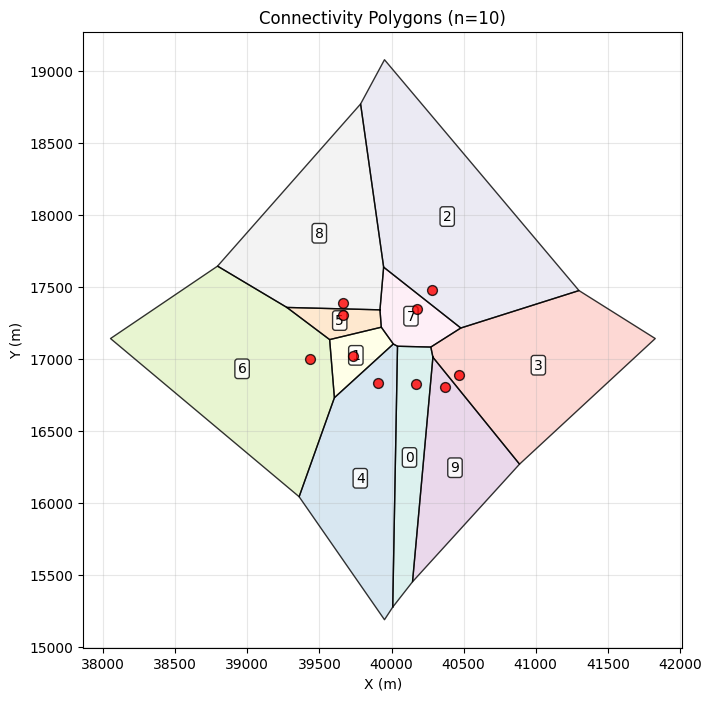

✓ Generated 10 polygons using voronoi method
✓ Saved to: C:\sedtrails-sgp\results\connectivity_test_output\voronoi_polygons.npy
✓ Saved to NetCDF: C:\sedtrails-sgp\results\connectivity_test_output\voronoi_polygons.nc

✓ Generated 10 Voronoi polygons


In [6]:
# Test Voronoi polygon generation
print("Testing Voronoi Polygon Generation")
print("="*40)

voronoi_results = tester.test_polygon_generation(
    method='voronoi',
    buffer_distance=1000.0,  # 2km buffer
    show_plots=True
)

print(f"\n✓ Generated {voronoi_results['n_polygons']} Voronoi polygons")

In [ ]:
# Test clustered polygon generation (with fixes for LineString and dimension mismatch)
print("Testing Clustered Polygon Generation")
print("="*40)

# Reload the modules to get all fixes
import importlib
import sys

modules_to_reload = [
    'sedtrails.simulation_analysis.connectivity.connectivity_polygons',
    'sedtrails.simulation_analysis.connectivity.connectivity_test',
    'sedtrails.simulation_analysis.connectivity.connectivity_io'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
        print(f"✓ Reloaded {module_name.split('.')[-1]}")

# Re-import and re-initialize tester to get updated modules
from sedtrails.simulation_analysis.connectivity.connectivity_test import ConnectivityTester

tester = ConnectivityTester(
    trajectory_file=TRAJECTORY_FILE,
    output_dir=OUTPUT_DIR
)

n_clusters = 5  # Adjust based on your data
clustered_results = tester.test_polygon_generation(
    method='clustered',
    n_clusters=n_clusters,
    show_plots=True
)

print(f"\n✓ Generated {clustered_results['n_polygons']} clustered polygons")
print("✓ LineString buffer issue resolved!")
print("✓ Dimension mismatch issue resolved!")

Testing Clustered Polygon Generation
✓ Reloaded connectivity_polygons module with LineString fix
Testing polygon generation with method: clustered
Removed 5 duplicate source points
Using 10 unique source locations


ValueError: conflicting sizes for dimension 'source_point_id': length 10 on 'polygon_assignments' and length 15 on {'polygon_id': 'polygon_coordinates', 'vertex_id': 'polygon_coordinates', 'coord_dim': 'polygon_coordinates', 'source_point_id': 'source_points'}

## 5. Test Adjacency Matrix Compilation

Compile adjacency matrices using different temporal aggregation methods.

In [ ]:
# Force reload of connectivity modules (run this if you encounter import issues)
import importlib
import sys

modules_to_reload = [
    'sedtrails.simulation_analysis.connectivity.connectivity_io',
    'sedtrails.simulation_analysis.connectivity.adjacency_matrix',
    'sedtrails.simulation_analysis.connectivity.connectivity_polygons',
    'sedtrails.simulation_analysis.connectivity.network_analysis',
    'sedtrails.simulation_analysis.connectivity.connectivity_test'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        print(f"Reloading {module_name}")
        importlib.reload(sys.modules[module_name])
    else:
        print(f"Module {module_name} not loaded yet")

# Re-import the main classes
from sedtrails.simulation_analysis.connectivity import (
    AdjacencyMatrixCompiler,
    ConnectivityPolygonGenerator,
    NetworkAnalyzer,
    ConnectivityIO
)
from sedtrails.simulation_analysis.connectivity.connectivity_test import ConnectivityTester

print("✓ Modules reloaded successfully!")
print("The latest fixes should now be active.")

In [ ]:
# Test adjacency compilation with Voronoi polygons
print("Testing Adjacency Matrix Compilation - Voronoi Polygons")
print("="*50)

voronoi_adj_results = tester.test_adjacency_compilation(
    polygon_file=voronoi_results['polygon_file'],
    modes=['final', 'all_time'],  # Test both temporal aggregation modes
    min_threshold=1,
    show_plots=True
)

print("\n✓ Adjacency compilation completed for Voronoi polygons")

## 6. Test Network Analysis

Analyze connectivity networks using NetworkX.

In [ ]:
# Test network analysis with Voronoi + final connectivity
print("Testing Network Analysis - Voronoi + Final Position")
print("="*50)

voronoi_final_network = tester.test_network_analysis(
    adjacency_data=voronoi_adj_results['final']['adjacency_data'],
    test_name="voronoi_final",
    show_plots=True
)

print(f"\n✓ Network: {voronoi_final_network['n_nodes']} nodes, {voronoi_final_network['n_edges']} edges")
print(f"  Density: {voronoi_final_network['density']:.3f}")

## 7. Results Summary

This notebook demonstrates the core functionality of the SedTrails connectivity analysis module:

- **Polygon Generation**: Created spatial regions using Voronoi tessellation and K-means clustering
- **Adjacency Compilation**: Built connectivity matrices with different temporal aggregation methods
- **Network Analysis**: Applied NetworkX algorithms for network metrics and visualization

### Next Steps:
- Run the full test suite using `tester.run_full_test_suite()`
- Customize parameters for your specific analysis needs
- Integrate with other SedTrails modules for comprehensive analysis

### Output Files:
All results are saved in the `connectivity_test_output` directory for further analysis.